## Data reading, observing it

In [3]:
import os
import time
import numpy as np
import seaborn as sns

import pandas as pd

from Bio import SeqIO
from pybedtools import BedTool
from tqdm.notebook import tqdm
from profilehooks import timecall

import matplotlib
import matplotlib.pyplot as plt
import pyranges as pr

In [4]:
link1 = '/home/fedor/Documents/HSE/2020-2021/Bioinformatics/data/hg38/input/quadruplex/quad_minus_hg38.bed'
bed1 = BedTool(link1).sort()
quad_minus = bed1.to_dataframe()
quad_minus['strand'] = '-'
quad_minus['length'] = quad_minus['end'] - quad_minus['start']
# quad_minus = quad_minus[quad_minus['length'] < 1000]

link2 = '/home/fedor/Documents/HSE/2020-2021/Bioinformatics/data/hg38/input/quadruplex/quad_plus_hg38.bed'
quad_plus = pr.read_bed(link2)
bed2 = BedTool(link2).sort()
quad_plus = bed2.to_dataframe()
quad_plus['strand'] = '+'
quad_plus['length'] = quad_plus['end'] - quad_plus['start']
# quad_plus = quad_plus[quad_plus['length'] < 1000]

quad = quad_plus.append(quad_minus)


link3 = '/home/fedor/Documents/HSE/2020-2021/Bioinformatics/data/hg38/input/ZDNA_datasets-master/Wu_hg38.bed'
bed3 = BedTool(link3).sort()
Z_dna = bed3.to_dataframe()
Z_dna['length'] = Z_dna['end'] - Z_dna['start']

array([[<AxesSubplot:title={'center':'length'}>]], dtype=object)

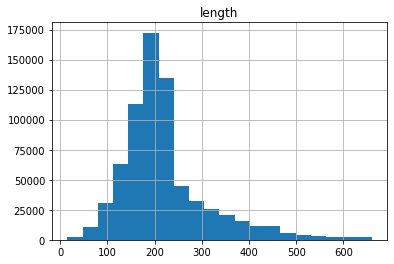

In [5]:
quad[quad['length'] <= quad['length'].quantile(0.99)].hist(column='length', bins=20)

In [6]:
del quad_minus, quad_plus

In [7]:
Z_dna.describe()

,start,end,length
count,4.551000e+03,4.551000e+03,4551.000000
mean,7.304377e+07,7.304444e+07,670.805757
std,5.772993e+07,5.772995e+07,1191.718044
min,1.120000e+02,1.022200e+04,84.000000
25%,2.835758e+07,2.835802e+07,194.000000
50%,5.847490e+07,5.847504e+07,342.000000
75%,1.083908e+08,1.083913e+08,686.000000
max,2.489457e+08,2.489464e+08,18220.000000


We see that mean size of Z dna is 670

array([[<AxesSubplot:title={'center':'length'}>]], dtype=object)

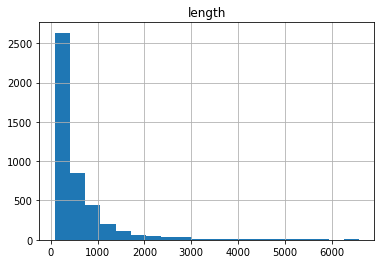

In [8]:
Z_dna[Z_dna['length'] <= Z_dna['length'].quantile(0.99)].hist(column='length', bins=20)

## Splitting to classes

We will have classes containing Z_dna and containing quadruplex

For model training we set a region to be of size 1000bp. 

So, in Z-DNA class we center them at 340 (average value), and the remaining region is symmetrucally distributed to the left and right flanks of Z-DNA. Final sample will include only those regions that do not contain quadruplexes

In quadruplex class we do the same, but for quadruplex.

In [9]:
Z_DNA = Z_dna[Z_dna['length'] <= 1000]
quad = quad[quad['length'] <= 1000]

In [10]:
del Z_dna

Пишем функцию для разархивации фрхива по имени

In [11]:
import gzip

def read_fasta(chr_name):
    path = '/home/fedor/Documents/HSE/2020-2021/Bioinformatics/data/hg38/input/genome/chromosomes/hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/'
    path = path + chr_name + '.fa.gz'
    f = gzip.open(path, 'rb')
    fasta = f.read()
    f.close()

    fasta = str(fasta.upper())
    
    new_fasta = []
    poss_nums = 'ATCG'
    for ch in fasta:
        if ch in poss_nums:
            new_fasta.append(ch)
    
    return new_fasta

In [12]:
# class 1 - only Z_DNA
def make_class_1(ZDNA, quad):
    new_rows = []
    for i, row in tqdm(ZDNA.iterrows()):
        start = row['start']
        end = row['end']
        length = row['length']
        chromo = row['chrom']
        
        flag = 1
        
        delta = 500 - int(length/2)
        left_border = start - delta
        right_border = end + delta
        
        quad_m = quad[quad['chrom'] == chromo]
        
        if (quad_m[(quad_m['start'] > left_border) & (quad_m['end'] < right_border)].shape[0] > 0):
            flag = 0
            
        if (quad_m[(quad_m['start'] < left_border) & (quad_m['end'] < right_border) & (quad_m['end'] > left_border)].shape[0] > 0):
            flag = 0
            
        if (quad_m[(quad_m['start'] > left_border) & (quad_m['end'] > right_border) & (quad_m['start'] < right_border)].shape[0] > 0):
            flag = 0
        
        if flag == 1:
            row['start'] = left_border
            row['end'] = right_border
            row['length'] = 1000
            new_rows.append(row)
    
    return pd.DataFrame(new_rows)

            
def make_class_2(ZDNA, quad):
    new_rows = []
    for i, row in tqdm(quad.iterrows()):
        start = row['start']
        end = row['end']
        length = row['length']
        chromo = row['chrom']

        
        flag = 1
        
        delta = 500 - int(length/2)
        left_border = start - delta
        right_border = end + delta
        
        ZDNA_m = ZDNA[ZDNA['chrom'] == chromo]

        
        if (ZDNA_m[(ZDNA_m['start'] > left_border) & (ZDNA_m['end'] < right_border)].shape[0] > 0):
            flag = 0
            
        if (ZDNA_m[(ZDNA_m['start'] < left_border) & (ZDNA_m['end'] < right_border) & (ZDNA_m['end'] > left_border)].shape[0] > 0):
            flag = 0
            
        if (ZDNA_m[(ZDNA_m['start'] > left_border) & (ZDNA_m['end'] > right_border) & (ZDNA_m['start'] < right_border)].shape[0] > 0):
            flag = 0
        
        if flag == 1:
            row['start'] = left_border
            row['end'] = right_border
            row['length'] = 1000
            new_rows.append(row)
            
    return pd.DataFrame(new_rows)

In [13]:
# some_f = read_fasta('chr1')

In [14]:
quad.head()

,chrom,start,end,strand,length
0,chr1,10000,10524,+,524
1,chr1,13933,14098,+,165
2,chr1,14218,14398,+,180
3,chr1,14428,14683,+,255
4,chr1,15058,15238,+,180


In [15]:
class_1 = make_class_1(Z_DNA, quad)
class_2 = make_class_2(Z_DNA, quad)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [16]:
all_set = set(class_1['chrom'].unique())
cl2_set = set(class_2['chrom'].unique())
all_set.update(cl2_set)

In [17]:
new_rows_cl1 = []
new_rows_cl2 = []

for chromosome in tqdm(all_set):
    class_1_chr = class_1[class_1['chrom'] == chromosome]
    class_2_chr = class_2[class_2['chrom'] == chromosome]
    
    nucleotides = read_fasta(chromosome)
    
    for i, row in class_1_chr.iterrows():
        start = row['start']
        end = row['end']
        
        if (end < len(nucleotides)):
            sequence = nucleotides[start : end]
            row['seq'] = ''.join(sequence)

            new_rows_cl1.append(row)
            
    new_rows_cl2 = []
    for i, row in class_2_chr.iterrows():
        start = row['start']
        end = row['end']
        
        if (end < len(nucleotides)):
            sequence = nucleotides[start : end]
            row['seq'] = ''.join(sequence)

            new_rows_cl2.append(row)
        
class1 = pd.DataFrame(new_rows_cl1)
class2 = pd.DataFrame(new_rows_cl2)

  0%|          | 0/38 [00:00<?, ?it/s]

In [19]:
class1.head()

,chrom,start,end,length,seq
2010,chr18,106490,107491,1000,CCCAACAGTGCAATTTGCTGGGTTATATGGTAAGCATATGTTTAGT...
2011,chr18,107683,108683,1000,TTCACCATGTTGTCCAGGCTGGTTTCGAACTCCTGACATCAGGTGA...
2012,chr18,109561,110561,1000,GCTGGGATTACAGGCGTGAGCCACCATGCCTGGCTGTTTAACTATT...
2014,chr18,299114,300115,1000,TTCTGCACTGAAAGAAGGACTTGTTCAAATGGACTCTGGGTTGAAA...
2018,chr18,13168321,13169322,1000,GAACAGAAAGAACTTAGCCTGAGGCCTGTTCCAGGGGCTCAGGGTG...


In [20]:
class1.to_csv('class1.csv', index=False)

In [21]:
class2.to_csv('class2.csv', index=False)

In [24]:
class1['strand'] = '1'

class1['class'] = 1

class2['class'] = 0

class1.head()

,chrom,start,end,length,seq,strand,class
2010,chr18,106490,107491,1000,CCCAACAGTGCAATTTGCTGGGTTATATGGTAAGCATATGTTTAGT...,1,1
2011,chr18,107683,108683,1000,TTCACCATGTTGTCCAGGCTGGTTTCGAACTCCTGACATCAGGTGA...,1,1
2012,chr18,109561,110561,1000,GCTGGGATTACAGGCGTGAGCCACCATGCCTGGCTGTTTAACTATT...,1,1
2014,chr18,299114,300115,1000,TTCTGCACTGAAAGAAGGACTTGTTCAAATGGACTCTGGGTTGAAA...,1,1
2018,chr18,13168321,13169322,1000,GAACAGAAAGAACTTAGCCTGAGGCCTGTTCCAGGGGCTCAGGGTG...,1,1


In [25]:
class2.head()

,chrom,start,end,strand,length,seq,class
32509,chr10,43699,44700,+,1000,ACTGACTGAGAGCTATGGCTCAGGATTAAAAATTCTTCTTTTTTCC...,0
32510,chr10,44187,45187,+,1000,CCCACTGCCCTTCCCAGCCTCTGGTAACCAACCTTATACTCTCTAT...,0
32511,chr10,46624,47625,+,1000,ACTTAACTATTGTGAGAATGGCTCCAAAGGAAATGATGCCAAACTG...,0
32512,chr10,47487,48487,+,1000,AGGTGGAGGCTCCCAAGTCTCAACTCTTGCATTTTGTACACTCACA...,0
32513,chr10,48590,49591,+,1000,TGCACATCACAGGGCAAAAAGCAGGAGCAGAAAACAGAGGGGCGAG...,0


In [26]:
classes = class1.copy()

In [27]:
classes = classes.append(class2)

In [28]:
classes.head()

,chrom,start,end,length,seq,strand,class
2010,chr18,106490,107491,1000,CCCAACAGTGCAATTTGCTGGGTTATATGGTAAGCATATGTTTAGT...,1,1
2011,chr18,107683,108683,1000,TTCACCATGTTGTCCAGGCTGGTTTCGAACTCCTGACATCAGGTGA...,1,1
2012,chr18,109561,110561,1000,GCTGGGATTACAGGCGTGAGCCACCATGCCTGGCTGTTTAACTATT...,1,1
2014,chr18,299114,300115,1000,TTCTGCACTGAAAGAAGGACTTGTTCAAATGGACTCTGGGTTGAAA...,1,1
2018,chr18,13168321,13169322,1000,GAACAGAAAGAACTTAGCCTGAGGCCTGTTCCAGGGGCTCAGGGTG...,1,1


In [29]:
classes.to_csv('classes_merged.csv', index=False)

In [30]:
class1.shape

(1555, 7)

In [31]:
class2.shape

(33270, 7)